In [1]:
import random as rnd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import time
import math
IOFOLDER='../../DGD_IO/'

In [2]:
def val(P,x):
    return P[0]+P[1]*x+P[2]*x*x
def grad(P,x):
    return P[1]+P[2]*2*x

In [3]:
def find(dsu,i):
    if dsu[i]==i:
        return i
    dsu[i]=find(dsu,dsu[i])
    return dsu[i]
def merge(dsu,i,j):
    dsu[find(dsu,i)]=find(dsu,j)
def connected(G):
    dsu=[i for i in range(len(G))]
    for i in range(len(G)):
        for j in G[i]:
            merge(dsu,i,j)
    for i in range(len(G)):
        if (find(dsu,i)!=find(dsu,0)):
            return (False,dsu)
    return (True,dsu)

In [15]:
listtonums=lambda A:str(list(A))[1:-1].replace(' ','')
PARSELIST=lambda s:list(map(float,s.split(',')))

In [322]:
#Pvals=['line']
#Pvals=[i/20 for i in range(1,21)]
Pvals=['line',0.05,0.1,0.25,0.5]
print('Pvals='+str(Pvals))
#params=[[50,Pvals[(i-1)//100],i] for i in range(1,len(Pvals)*100+1)]
params=[[50,Pvals[i-1],1] for i in range(1,len(Pvals)+1)]
fin=open(IOFOLDER+'input.txt','w')
for param in params:
    N,P,seed=param
    fin.write('N,P,seed={},{},{}\n'.format(N,P,seed))
    rnd.seed(seed)
    att=0
    while True:
        if P=='line':
            graph=[list(range(max(0,i-1),min(N,i+2))) for i in range(N)]
        else:
            graph=[[] for i in range(N)]
            for i in range(N):
                for j in range(i):
                    if rnd.random()<P:
                        graph[i].append(j)
                        graph[j].append(i)
                graph[i].append(i)
        info=connected(graph)
        att+=1
        if info[0]:
            break
    if seed%100==0:
        print(str(param)+'; # attempts='+str(att))

    #functions
    funcs=[]
    for i in range(N):
        a=rnd.uniform(0,1)
        v=rnd.uniform(-100,100)
        #(ax-v)^2=a^2x^2-2avx+v^2
        funcs.append(np.array([v*v,-2*a*v,a*a]))
    tfunc=np.array([0.0 for i in range(3)])
    for func in funcs:
        tfunc+=func
    tfunc/=N
    optx=-tfunc[1]/(2*tfunc[2])
    optval=val(tfunc,optx)
    #print(str(optx)+','+str(optval))
    locs0=[rnd.uniform(-200,200) for i in range(N)]
    #print('mean starting loc='+str(np.mean(locs0)))
    
    for i in range(N):
        fin.write(str(i)+':'+listtonums(graph[i])+'\n')
    for i in range(N):
        fin.write(str(i)+':'+listtonums(funcs[i])+'\n')
    fin.write(listtonums(locs0)+'\n')

    #graph network visualization
    '''groups=[[] for i in range(N)]
    for i in range(N):
        groups[find(info[1],i)].append(i)
    seq=[]
    for g in groups:
        seq.extend(g)
    locs=[[] for i in range(N)]
    for i in range(N):
        t=2*math.pi*i/N
        locs[seq[i]]=[math.cos(t),math.sin(t)]
    plt.figure()
    amt=0
    for g in groups:
        if len(g)>0:
            amt+=1
    tmp=0
    for g in groups:
        if len(g)>0:
            col=(1-tmp/amt,0,tmp/amt)
            for i in g:
                for j in graph[i]:
                    plt.plot([locs[i][0],locs[j][0]],[locs[i][1],locs[j][1]],linewidth=1,c=col)
            plt.scatter(x=[locs[i][0] for i in g],y=[locs[i][1] for i in g],s=40,c=[col for i in g])
            tmp+=1'''

fin.close()

Pvals=['line', 0.05, 0.1, 0.25, 0.5]


In [177]:
def readrets(file):
    info=open(IOFOLDER+file,'r').read().split('\n')
    A,ITER=list(map(int,info[0].split('=')[1].split(',')))
    data={}
    Tvals=set()
    param=seed=T=optloc=optscr=None
    for i in range(1,len(info)):
        pcs=info[i].split('=')
        if len(pcs)==1:
            continue
        k=pcs[0]
        if k=='N,P,seed':
            split=pcs[1].rindex(',')
            param=pcs[1][:split]
            seed=pcs[1][split+1:]
            if not(param in data):
                data[param]={}
            data[param][seed]={}
        elif k=='T':
            T=pcs[1]
            Tvals.add(T)
            data[param][seed][T]={}
        elif k=='optloc,optscr':
            optloc,optscr=PARSELIST(pcs[1])
            data[param][seed]['optloc']=optloc
            data[param][seed]['optscr']=optscr
        else:
            tmp=PARSELIST(pcs[1][1:-1]) if pcs[1][0]=='[' else float(pcs[1])
            data[param][seed][T][k]=tmp
    param=seed=T=optloc=optscr=None
    #print(data)
    Tvals=list(reversed(sorted(list(Tvals))))
    return (A,ITER,Tvals,data)

<IPython.core.display.Javascript object>


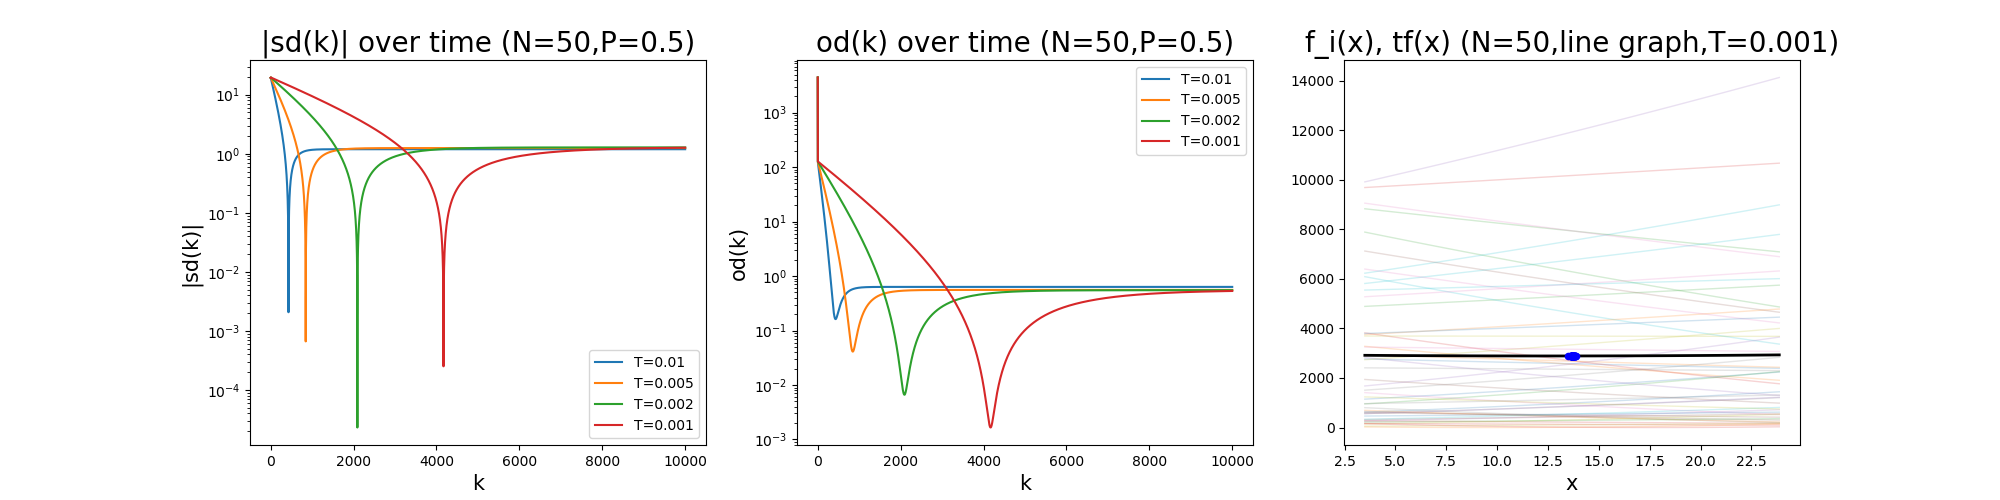

[ 2.93780401e+03 -8.23825799e+00  3.31029061e-01]
optloc=12.443405970949282 optscr=2886.5480206450948
gap=0.06276942803181029


In [327]:
equiv=False
A,ITER,Tvals,data=readrets('stats_out_A=0'+('_equivocate' if equiv else '')+'.txt')
N,P,seed=50,'0.5',1
rdata=data['{},{}'.format(N,P)][str(seed)]
fig,(sold,objd,extra)=plt.subplots(1,3,figsize=(20,5))

title_help=' over time (N={},P={},A={})'.format(N,P,A)
if A==0:
    title_help=' over time (N={},P={})'.format(N,P)
sold.set_title('|sd(k)|'+title_help,fontsize=20)
sold.set_xlabel('k',fontsize=15)
sold.set_ylabel('|sd(k)|',fontsize=15)
sold.set_yscale('log')
for T in Tvals:
    sold.plot(list(map(abs,rdata[T]['msoldiff'])),label='T='+str(T))
sold.legend()

objd.set_title('od(k)'+title_help,fontsize=20)
objd.set_xlabel('k',fontsize=15)
objd.set_ylabel('od(k)',fontsize=15)
objd.set_yscale('log')
for T in Tvals:
    objd.plot(rdata[T]['mobjdiff'],label='T='+str(T))
objd.legend()

extra.set_title('f_i(x), tf(x) (N=50{},line graph,T=0.001)'
                .format((',A='+str(A)+(' (equivocate)' if equiv else '')) if A>0 else ''),fontsize=20)
extra.set_xlabel('x',fontsize=15)
locsfin=rdata['0.001']['locs_fin']
xs=np.linspace(np.min(locsfin)-10,np.max(locsfin)+10,100)
tf=0
for f in funcs:
    tf+=f
tf/=N
print(tf)
print('optloc='+str(-tf[1]/(2*tf[2]))+' optscr='+str(val(tf,(-tf[1]/(2*tf[2])))))
for f in funcs:
    extra.plot(xs,list(map(lambda x:val(f,x),xs)),linewidth=1,alpha=0.2,zorder=1)
extra.plot(xs,list(map(lambda x:val(tf,x),xs)),linewidth=2,c='black',zorder=1)
#extra.set_xlim(-15,15)
#extra.set_ylim(2800,3000)
extra.scatter(locsfin,list(map(lambda x:val(tf,x),locsfin)),s=20,c='blue',zorder=2)
print('gap='+str(rdata['0.001']['locsgap_fin']))
fig.savefig('tmp.png',bbox_inches='tight')

<IPython.core.display.Javascript object>


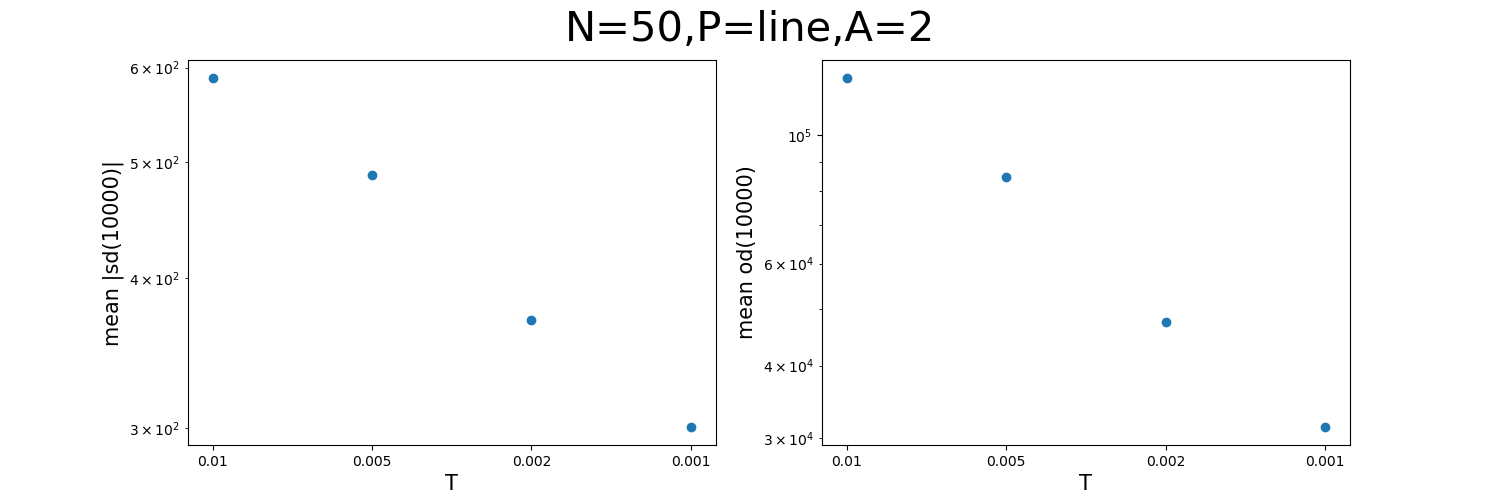

In [329]:
#when P='line'
equiv=False
A,ITER,Tvals,data=readrets('A=2'+('_equivocate' if equiv else '')+',P=line.txt')
fig,(msd,mod)=plt.subplots(1,2,figsize=(15,5))
title='N=50,P=line,A={}'.format(A)+(' (equivocate)' if equiv else '')#+', equivocating adversary'
if A==0:
    title='N=50,P=line'
fig.suptitle(title,fontsize=30)
p='50,line'

msd.set_xlabel('T',fontsize=15)
msd.set_ylabel('mean |sd({})|'.format(ITER),fontsize=15)
msd.scatter(x=Tvals,y=[np.mean([abs(data[p][seed][T]['msoldiff_fin']) for seed in data[p]]) for T in Tvals])
msd.set_yscale('log')

mod.set_xlabel('T',fontsize=15)
mod.set_ylabel('mean od({})'.format(ITER),fontsize=15)
mod.scatter(x=Tvals,y=[np.mean([data[p][seed][T]['mobjdiff_fin'] for seed in data[p]]) for T in Tvals])
mod.set_yscale('log')

fig.savefig('tmp.png',bbox_inches='tight')

<IPython.core.display.Javascript object>


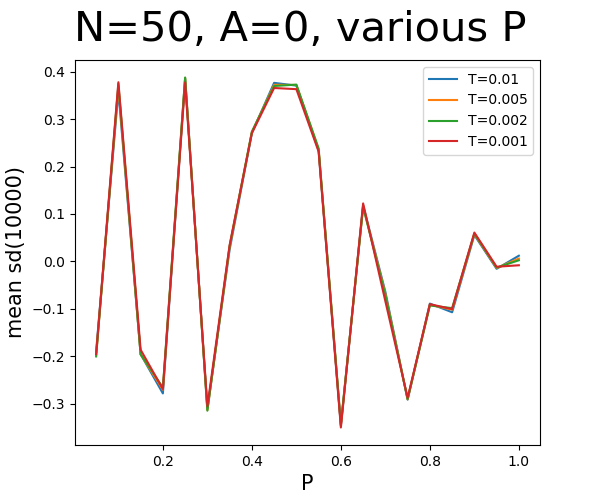

['50,0.05', '50,0.1', '50,0.15', '50,0.2', '50,0.25', '50,0.3', '50,0.35', '50,0.4', '50,0.45', '50,0.5', '50,0.55', '50,0.6', '50,0.65', '50,0.7', '50,0.75', '50,0.8', '50,0.85', '50,0.9', '50,0.95', '50,1.0']


In [339]:
equivocate=False
A,ITER,Tvals,data=readrets('A=0'+('_equivocate' if equivocate else '')+',P=0.05k.txt')
AXS=1
msd=mrsd=mod=mgap=None
fig,axs=plt.subplots(1,AXS,figsize=(6*AXS,5))
if AXS==1:
    axs=[axs]
title=('N=50, A={}'+(' (equivocate)' if equivocate else '')+', various P').format(A)#+', equivocating adversary'
# if A==0:
#     title='N=50, various P'
fig.suptitle(title,fontsize=30)
params=[p for p in data]
print(params)
pvals=list(map(lambda p:float(p[p.rindex(',')+1:]),params))

def plotmeans(ax,key,func,ylabel,log):
    ax.set_xlabel('P',fontsize=15)
    ax.set_ylabel(ylabel,fontsize=15)
    if log:
        ax.set_yscale('log')
    for T in Tvals:
        ax.plot(pvals,
                list(map(lambda p:np.mean([func(data[p][seed][T][key]) for seed in data[p]]),params)),
                label='T='+str(T))
    ax.legend()

# plotmeans(axs[0],'msoldiff_fin',abs,'mean |sd({})|'.format(ITER),True)
# plotmeans(axs[1],'mobjdiff_fin',lambda x:x,'mean od({})'.format(ITER),True)
# if AXS>2:
plotmeans(axs[0],'msoldiff_fin',lambda x:x,'mean sd({})'.format(ITER),False)
# if AXS>3:
#     plotmeans(axs[3],'locsgap_fin',lambda x:x,'mean gap({})'.format(ITER),True)
#     axs[3].set_title(title,fontsize=24)
fig.savefig('tmp.png',bbox_inches='tight')

<IPython.core.display.Javascript object>


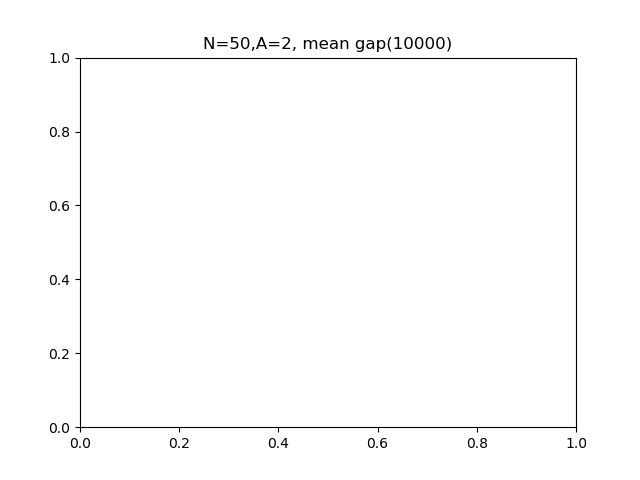

Text(0.5, 1.0, 'N=50,A=2, mean gap(10000)')

In [242]:
equiv=False
A,ITER,Tvals,data=readrets('A=1'+('_equivocate' if equiv else '')+',P=0.05k.txt')
fig,mgap=plt.subplots()
title=('N=50,A={}'+(' (equivocate)' if equivocate else '')).format(A)
mgap.set_title(title+', mean gap({})'.format(ITER))
